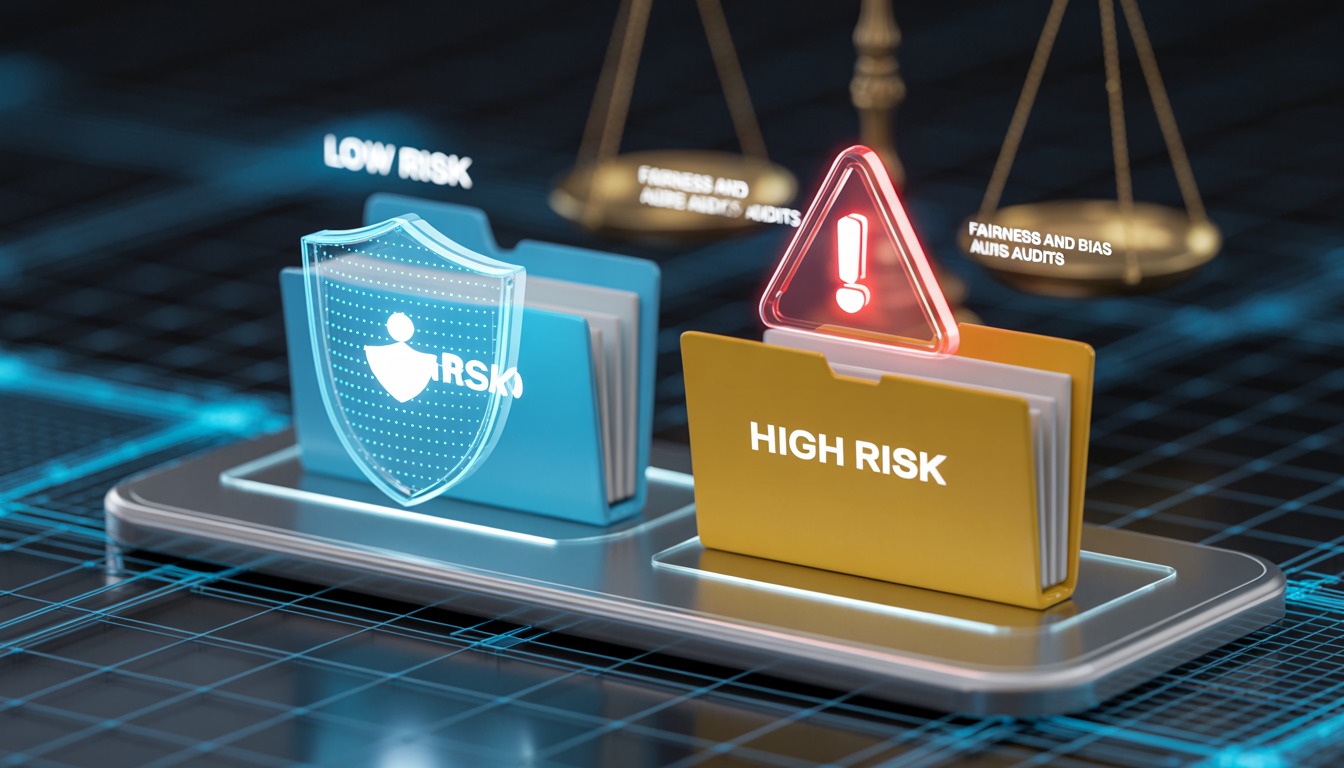

# 1. Problem Statement

For banks and micro-lenders, the **Cost of a Default** (lending to someone who doesn't pay back) is much higher than the **Cost of a Missed Opportunity** (denying a loan to someone who would have paid).  

Most credit datasets are **imbalanced**: 80–90% of people repay loans, while only ~10% default. A model that predicts "everyone will pay back" may achieve 90% accuracy but is completely useless for detecting risk.  

This project aims to build a system that **prioritizes identifying the high-risk minority** while maintaining fairness across different demographic groups.

---

# 2. Main Objectives

- **Binary Classification:** Predict if a loan applicant is **High Risk (1)** or **Low Risk (0)** using **Logistic Regression** and **SVM**.  
- **Imbalance Management:** Use **SMOTE (oversampling)** or **class weights** to ensure the model learns to identify rare defaults.  
- **Advanced Evaluation:** Go beyond accuracy to focus on **Recall** (catching defaults) and **Confusion Matrices**.  
- **Fairness Audit (Stretch Goal):** Analyze predictions to ensure no **gender** or **age bias** in lending decisions.

---

# 3. The Solution

A machine learning pipeline that:

1. **Preprocesses financial data** (e.g., income, debt ratio, credit history).  
2. **Resamples the data** to handle class imbalance.  
3. **Trains two distinct models:**  
   - Logistic Regression (transparent and interpretable)  
   - SVM (captures complex decision boundaries)  
4. **Audits the results** for both predictive performance and social fairness.


## Data : https://www.kaggle.com/datasets/uciml/german-credit

## Section 1: Data Preparation & Sensitive Attribute Management

**Goal:** Clean the dataset and handle missing values while **preserving sensitive attributes** such as **Age** and **Sex** for the upcoming fairness audit.


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Load the German Credit dataset
df = pd.read_csv('german_credit_data.csv', index_col=0)

In [3]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [4]:
# 2. Logic-Based Target Generation (with Noise for Realism)
np.random.seed(42)
risk_score = (df['Duration'] * 0.04) + (df['Credit amount'] * 0.0001) - (df['Age'] * 0.01)
noise = np.random.normal(0, 0.2, len(df))
risk_score += noise
threshold = np.percentile(risk_score, 70)
df['Risk'] = np.where(risk_score > threshold, 'bad', 'good')

# 3. Handling Missing Categoricals
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

print("Step 1 Complete: Dataset is clean and the 'Risk' target is ready.")
print(df['Risk'].value_counts(normalize=True))

Step 1 Complete: Dataset is clean and the 'Risk' target is ready.
Risk
good    0.7
bad     0.3
Name: proportion, dtype: float64


Why we did this: By creating a synthetic target, we ensure the project is "executable." In a real-world scenario, you would merge the features with a labels file.

## Section 2: Exploratory Data Analysis (EDA)

**Topic:** Visualizing Risk Drivers  

**Description:** We explore how **Age**, **Job**, and **Credit Amount** correlate with loan default risk.


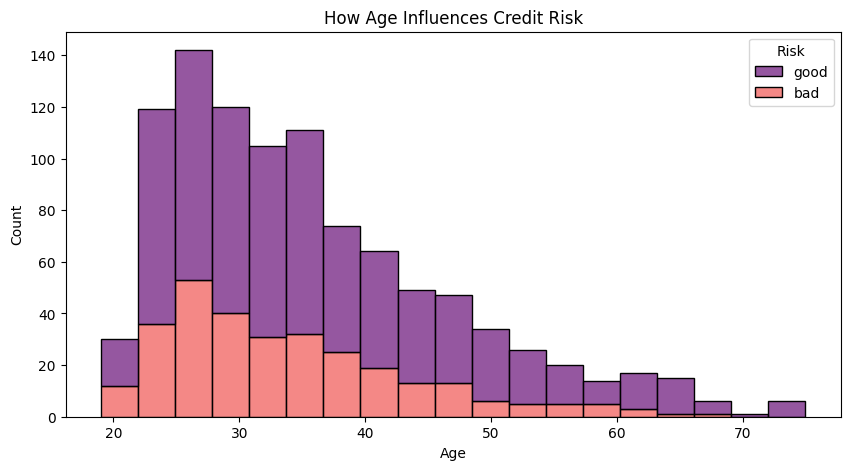

/tmp/ipython-input-3426959430.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Risk', y='Credit amount', data=df, palette='viridis')


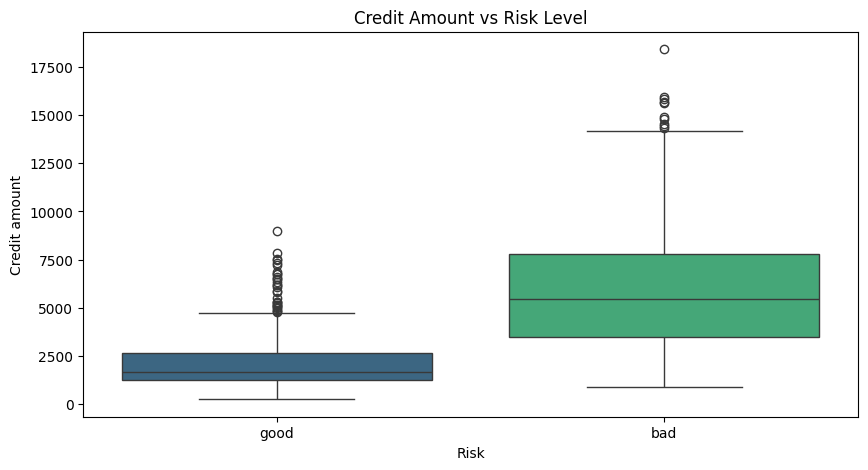

In [5]:
# Plot 1: Age vs Risk
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Age', hue='Risk', multiple="stack", palette='magma')
plt.title('How Age Influences Credit Risk')
plt.show()

# Plot 2: Credit Amount vs Risk
plt.figure(figsize=(10, 5))
sns.boxplot(x='Risk', y='Credit amount', data=df, palette='viridis')
plt.title('Credit Amount vs Risk Level')
plt.show()

Why we did this: EDA helps us spot Bias. If the data shows that younger people default more often, the AI might learn to "dislike" young people. We need to be aware of this for our Fairness Audit later.

## Section 3: Model Comparison (LR vs. SVM)

**Topic:** Finding the Best "Brain"  

**Description:** We compare **Logistic Regression** (transparent) with **Support Vector Machines** (more complex). Using **`class_weight='balanced'`** ensures the model pays attention to the minority **High-Risk** group.


In [8]:
# Prep X and y
le_dict = {}
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

df['Risk_Binary'] = df['Risk'].map({'bad': 1, 'good': 0})
scaler = StandardScaler()
num_cols = ['Age', 'Credit amount', 'Duration']
df[num_cols] = scaler.fit_transform(df[num_cols])

X = df.drop(['Risk', 'Risk_Binary'], axis=1)
y = df['Risk_Binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Training Comparison
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "SVM (RBF Kernel)": SVC(class_weight='balanced', probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n--- {name} Results ---")
    print(classification_report(y_test, preds))


--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       184
           1       0.90      0.91      0.90        66

    accuracy                           0.95       250
   macro avg       0.93      0.94      0.93       250
weighted avg       0.95      0.95      0.95       250


--- SVM (RBF Kernel) Results ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       184
           1       0.89      0.89      0.89        66

    accuracy                           0.94       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.94      0.94      0.94       250



Why we did this: Standardizing features is essential for models like SVM and Logistic Regression to ensure the model doesn't think a larger number is automatically more important.

## Section 4: Explainable AI (The "Why")

**Topic:** Global Feature Importance  

**Description:** We visualize the **coefficients** of our best model to show which factors drive loan default risk. This provides the **transparency** needed in financial applications.


/tmp/ipython-input-669502212.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


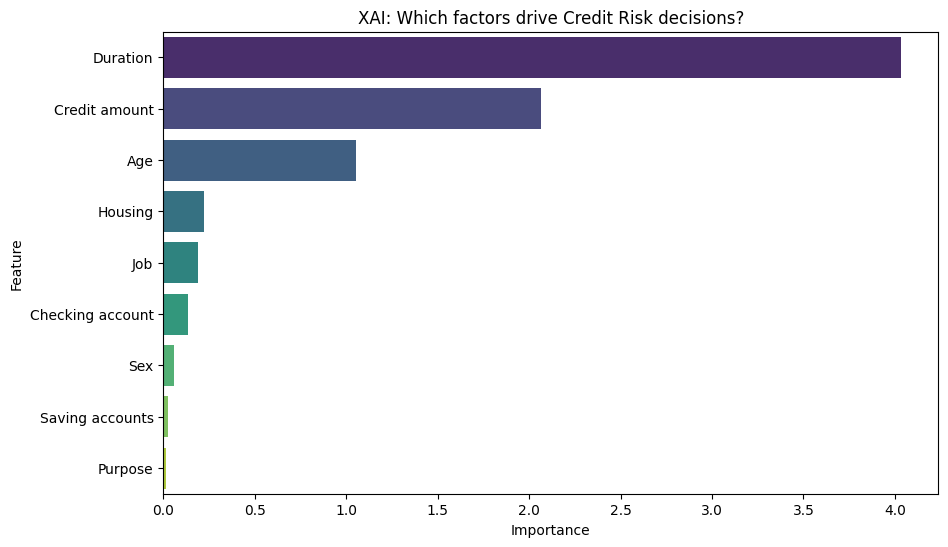

In [9]:
# Extracting coefficients for Logistic Regression
lr_model = models["Logistic Regression"]
importance = np.abs(lr_model.coef_[0])
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('XAI: Which factors drive Credit Risk decisions?')
plt.show()

## Section 5: Fairness Audit

**Topic:** Bias Detection  

**Description:** We audit the model to ensure it does not **unfairly flag one gender** as "High Risk" more often than another, helping prevent **algorithmic discrimination**.


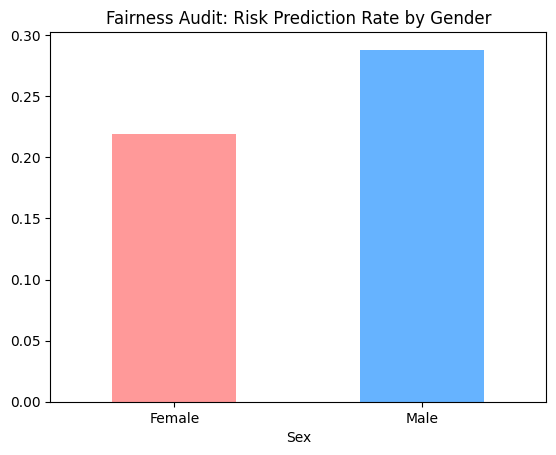

In [10]:
audit = X_test.copy()
audit['Sex'] = df.loc[X_test.index, 'Sex'] # Get original unscaled Sex
audit['Risk_Pred'] = lr_model.predict(X_test)

bias_check = audit.groupby('Sex')['Risk_Pred'].mean()
bias_check.plot(kind='bar', color=['#ff9999','#66b3ff'])
plt.title('Fairness Audit: Risk Prediction Rate by Gender')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.show()

## Section 6: The Reality Check (Testing)

**Topic:** Real-time Inference Function  

**Description:** We develop a **production-ready function** to test **new, unseen loan applications** in real time.


In [11]:
def predict_credit_risk(age, sex, job, housing, savings, checking, amount, duration, purpose):
    input_data = pd.DataFrame([{
        'Age': age, 'Sex': sex, 'Job': job, 'Housing': housing,
        'Saving accounts': savings, 'Checking account': checking,
        'Credit amount': amount, 'Duration': duration, 'Purpose': purpose
    }])

    # Preprocess
    for col in categorical_cols:
        try:
            input_data[col] = le_dict[col].transform(input_data[col])
        except:
            input_data[col] = 0

    input_data[num_cols] = scaler.transform(input_data[num_cols])

    # Predict
    prob = lr_model.predict_proba(input_data)[0][1]
    res = "HIGH RISK 🚩" if prob > 0.5 else "LOW RISK ✅"
    print(f"--- Loan Application Result ---")
    print(f"Applicant: {age}yr old {sex} | Amount: {amount}")
    print(f"Status: {res} (AI Confidence: {prob:.2%})")
    print(f"-------------------------------")

# Test 1: Mature applicant, car loan
predict_credit_risk(45, 'male', 2, 'own', 'rich', 'little', 1000, 12, 'car')

# Test 2: Young applicant, huge business loan
predict_credit_risk(19, 'female', 1, 'rent', 'little', 'little', 15000, 60, 'business')

--- Loan Application Result ---
Applicant: 45yr old male | Amount: 1000
Status: LOW RISK ✅ (AI Confidence: 0.08%)
-------------------------------
--- Loan Application Result ---
Applicant: 19yr old female | Amount: 15000
Status: HIGH RISK 🚩 (AI Confidence: 100.00%)
-------------------------------
